### SenseFly: Small Village. *(37 oblique images)*

([Sullens; District du Gros-de-Vaud, Switzeland](https://www.openstreetmap.org/#map=17/46.59398/6.56794))

**Exploratory analysis and result**

In [1]:
import os
import glob

import math
import numpy as np
from laspy.file import File
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1 import AxesGrid

import seaborn as sns

from osgeo import gdal

**pose and dense reconstruction** *(openMVG -> openMVS)*

<img src="./img/pose_and_Dcloud.png" width="600" height="400" align="center"/>

**after PDAL**

In [8]:
#Read LAS file
inFile = File("./result_utm/las/sceneGeo_dense.las", mode = "r")

In [9]:
print('Examining Point Format: ')
pointformat = inFile.point_format
for spec in inFile.point_format:
    print(spec.name)

Examining Point Format: 
X
Y
Z
intensity
flag_byte
raw_classification
scan_angle_rank
user_data
pt_src_id
gps_time
red
green
blue


In [10]:
#import LAS into numpy array 
rgb_points = np.array((inFile.x, inFile.y, inFile.z, inFile.raw_classification,
                         inFile.red, inFile.green, inFile.blue
                        )).transpose() # inFile.return_number,
inFile.close()
#colors = np.vstack((inFile.red, inFile.green, inFile.blue)).transpose()
print(len(rgb_points))

1725377


In [11]:
#Transform to pandas DataFrame
rgb_df = pd.DataFrame(rgb_points, columns=['x', 'y', 'z', 'class', 'r', 'g', 'b'])
rgb_df.describe()

,x,y,z,class,r,g,b
count,1.725377e+06,1.725377e+06,1.725377e+06,1.725377e+06,1.725377e+06,1.725377e+06,1.725377e+06
mean,3.136540e+05,5.162957e+06,6.486196e+02,1.111748e+00,1.266310e+02,1.214223e+02,1.048139e+02
std,5.049221e+01,5.564032e+01,4.343762e+00,3.150567e-01,6.049285e+01,5.040082e+01,4.993030e+01
min,3.134678e+05,5.162742e+06,6.333200e+02,1.000000e+00,5.000000e+00,7.000000e+00,5.000000e+00
25%,3.136165e+05,5.162915e+06,6.459300e+02,1.000000e+00,7.900000e+01,8.600000e+01,6.500000e+01
50%,3.136512e+05,5.162954e+06,6.475800e+02,1.000000e+00,1.270000e+02,1.220000e+02,1.010000e+02
75%,3.136877e+05,5.162995e+06,6.517900e+02,1.000000e+00,1.750000e+02,1.580000e+02,1.390000e+02
max,3.138541e+05,5.163162e+06,6.722100e+02,2.000000e+00,2.550000e+02,2.550000e+02,2.550000e+02


In [12]:
rgb_df.head(3)

,x,y,z,class,r,g,b
0,313603.39,5163028.99,644.30,2.0,175.0,162.0,124.0
1,313603.64,5163028.96,644.31,2.0,182.0,168.0,132.0
2,313603.97,5163028.55,644.69,1.0,174.0,161.0,122.0


In [13]:
print('diff x:', rgb_df.x.min() - rgb_df.x.max())
print('diff y:', rgb_df.y.min() - rgb_df.y.max())
print('diff z:', rgb_df.z.min() - rgb_df.z.max())

diff x: -386.28999999997905
diff y: -420.47000000067055
diff z: -38.889999999999986


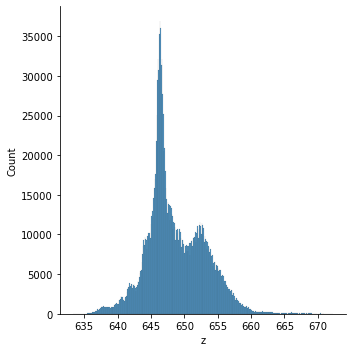

In [14]:
sns.displot(rgb_df.z)
plt.show()

In [15]:
factor=30
decimated_points_random = rgb_df[::factor]
print(len(decimated_points_random))

57513


In [16]:
decimated_points_random['class'].unique()

array([2., 1.])

In [17]:
extent = x_min, x_max, y_min, y_max = [rgb_df.x.min()-25, 
                                       rgb_df.x.max()+25,
                                       rgb_df.y.min()-25, 
                                       rgb_df.y.max()+25]
extent

[313442.84, 313879.13, 5162716.64, 5163187.11]

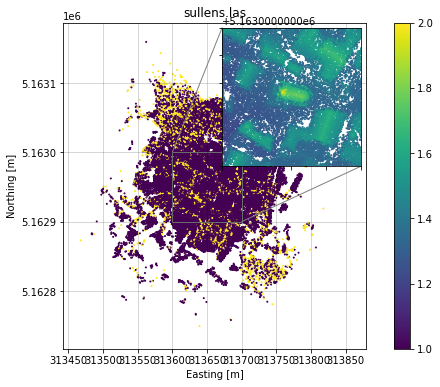

In [40]:
fig, ax = plt.subplots(figsize=(10,6))

cm = ax.scatter(decimated_points_random.x, decimated_points_random.y, 
                c=decimated_points_random['class'], 
                #c=decimated_points_random.z,
                s=1)

ax.set_aspect(1)
ax.set_xlim(*extent[:2])
ax.set_ylim(*extent[2:])
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.set_title('sullens.las')
ax.grid(c='k', alpha=0.2)
fig.colorbar(cm)

axins = zoomed_inset_axes(ax, 2, loc=1)
axins.scatter((decimated_points_random.x), (decimated_points_random.y), 
              c=decimated_points_random.z,
              #c=decimated_points_random['class'],
              s=1)
axins.set_xlim(313600, 313700)
axins.set_ylim(5162900, 5163000)  # 5162900, 5163000
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax, axins, loc1=4, loc2=2, fc="none", ec="0.5")

plt.show()

**dtm_dsm**

In [2]:
files = glob.glob(os.path.join('./result_utm/*.tif'))
img_l = []
char2 = '.asc'
for file in files:
    ds = gdal.Open(file)#.ReadAsArray()
    array = ds.ReadAsArray()
    array  = np.flip(array, 0)
    nan_array = array
    nan_array[array == -9999] = np.nan
    img_l.append(nan_array)
    # close dataset
    ds = None
print(files)

['./result_utm\\sceneGeo_dense_dsm_idwQUAD.tif', './result_utm\\sceneGeo_dense_dtm_tinLaplace.tif']


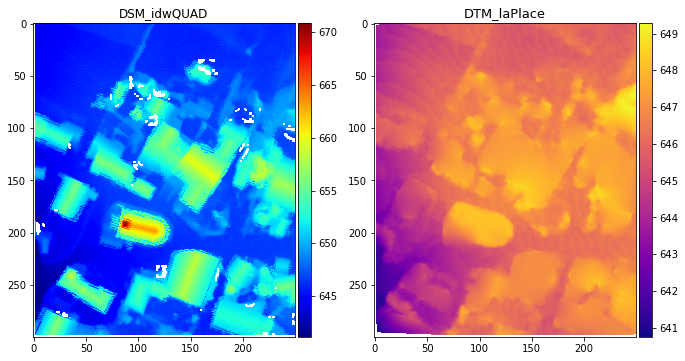

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(14,6), sharey=True)

ax = plt.subplot(131)
cf = plt.imshow(img_l[0], cmap=plt.cm.jet)
ax.set_title('DSM_idwQUAD', fontdict={'fontsize': 12, 'fontweight': 'medium'})
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cf, cax=cax)

ax = plt.subplot(132)
cb = plt.imshow(img_l[1], cmap=plt.cm.plasma)
ax.set_title('DTM_laPlace', fontdict={'fontsize': 13, 'fontweight': 'medium'})
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cb, cax=cax)
#plt.colorbar()
fig.tight_layout()
plt.show()